In [38]:
import numpy as np
from dotenv import load_dotenv
from sentle import sentle
import geopandas as gpd
from pathlib import Path
import os
import torch
import xarray as xr
import matplotlib as plt
# import fiona

In [133]:
env_path = Path('/net/projects/EO4BK/WP1/P1-EO4BK/scripts/EO4BK-WP1-P1/.env')
load_dotenv(dotenv_path=env_path)
# Set resolution of the grid that  i want to load
res = 10
# Path to LUCAS Copernicus file
lcs_poly_path = f"{os.getenv('LUCAS_CPN_POLY')}/l2022_survey_cop_radpoly_attr.gpkg"
lcs_cpns_poly_data = gpd.read_file(lcs_poly_path)
output_zarr_path = f"{os.getenv('MINICUBES_PATH')}/0_{res}_512_20152024_equi7_NA.zarr"
polygon = lcs_cpns_poly_data[0:1]
# polygon
polygon

,point_id,user_id,point_nuts0,pi_extension,point_ex_ante,point_lat,point_long,point_altitude,point_copernicus,point_grassland,...,lu1_code,poly_area_sqm,surveycprncando,surveycprnlc1n,surveycprnclc1e,surveycprnclc1w,surveycprnclc1s,surveycprnlc,col_hex,geometry
0,45782848,DESU029,DE,0,0,48.69058,13.49097,513,1,0,...,U120,2079.466217,1,51,3,3,2,C10,00a600,"POLYGON ((4.58e+06 2.85e+06, 4.58e+06 2.85e+06..."


In [ ]:
# Set CUDA environment
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
print(f"> Available CUDA devices: {torch.cuda.device_count()}")

In [134]:
bounds = lcs_cpns_poly_data[0:1].geometry.iloc[0].bounds
bound_left = int(bounds[0])
bound_bottom = int(bounds[1])
bound_right = int(bounds[2])
bound_top = int(bounds[3])
equi7_crs = lcs_cpns_poly_data.crs
print(f"Resolution: {res}")

da = sentle.process(
    target_crs=equi7_crs,
    bound_left=bound_left,
    bound_bottom=bound_bottom,
    bound_right=bound_right,
    bound_top=bound_top,
    datetime="2024-05-01/2024-07-31",
    target_resolution=20,
    S2_mask_snow=True,
    S2_cloud_classification=True,
    S2_cloud_classification_device="cuda",
    S1_assets=["vv", "vh"],
    S2_apply_snow_mask=True,
    S2_apply_cloud_mask=True,
    time_composite_freq="7d",
    # NOTE clemens: this can be set to 40
    num_workers=7,
)

sentle.save_as_zarr(da, path=output_zarr_path)

Resolution: 10


/net/home/dschierbaum/.conda/envs/wp1/lib/python3.11/site-packages/sentle/sentle.py:881: UserWarning: Specified top/bottom bounds are not perfectly divisable by specified target_resolution. The resulting coverage will be rounded up to the next pixel value.
  warnings.warn(
/net/home/dschierbaum/.conda/envs/wp1/lib/python3.11/site-packages/sentle/sentle.py:888: UserWarning: Specified left/right bounds are not perfectly divisable by specified target_resolution. The resulting coverage will be rounded up to the next pixel value.
  warnings.warn(


In [135]:
test_minicube = xr.open_zarr(output_zarr_path)
test_minicube.sentle

<xarray.DataArray 'sentle' (time: 14, band: 14, y: 2, x: 3)> Size: 5kB
dask.array<open_dataset-sentle, shape=(14, 14, 2, 3), dtype=float32, chunksize=(1, 12, 2, 3), chunktype=numpy.ndarray>
Coordinates:
  * band     (band) <U3 168B 'B01' 'B02' 'B03' 'B04' ... 'B11' 'B12' 'vv' 'vh'
  * time     (time) datetime64[ns] 112B 2024-08-01 2024-07-25 ... 2024-05-02
  * x        (x) float32 12B 4.578e+06 4.578e+06 4.578e+06
  * y        (y) float32 8B 2.848e+06 2.848e+06

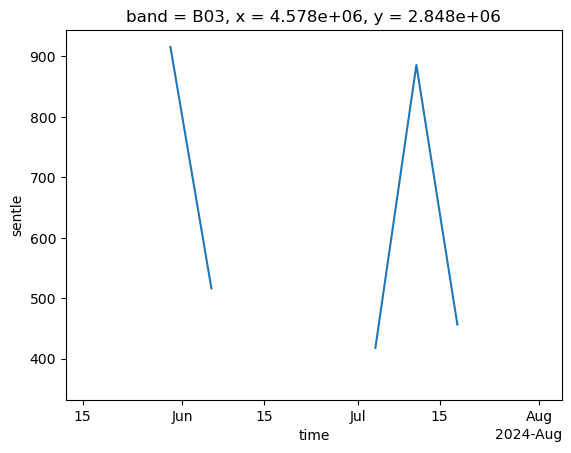

In [136]:
# Plot Time-Series

ds_band = test_minicube.sel(band = ['B03','B04','B05'])
singleband = ds_band.sel(band = 'B03')
pixel_timeseries = singleband.isel(x = 1, y = 1)
pixel_timeseries.sentle.plot()

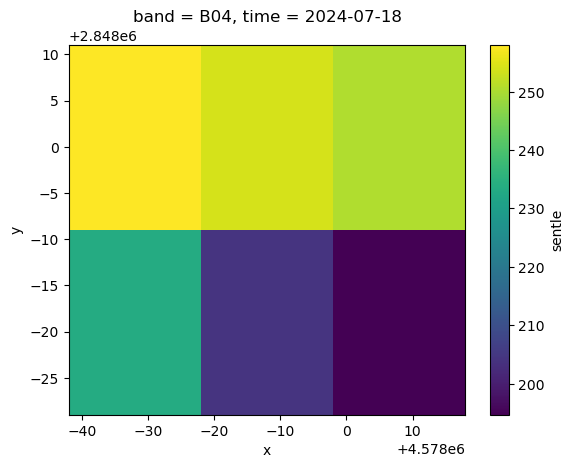

In [137]:
# Plot Map 
# Extract the time series for the specified pixel and band
spatial = ds_band.isel(time=2)
spatial.sentle.sel(band =['B04']).plot()